# Тестовое задание для АО "НИИАС"
Альтернативное решение. Построил модель распознания не каждой цифры номера, как класса(Yolo), а всего номера с помощью предобученнной модели trocr-large-printed (модель оптического распознавания печатных символов).

## План реализации

- Загрузка данных
- Предобработка и исследовательский анализ данных
- Обучение модели на архитектуре TrOCR
- Вывод

## Инструменты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from pandas import option_context

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import re

from tqdm.notebook import tqdm
tqdm.pandas()

import os
from os import path

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

sns.set(style="darkgrid",font_scale=1.5)


## Загрузка данных

In [3]:
pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00


In [4]:
%load_ext watermark
%watermark -a 'Recognition for RZD' -u -d -v -p pandas,sklearn,numpy,matplotlib,seaborn

Author: Recognition for RZD

Last updated: 2024-05-15

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas    : 2.0.3
sklearn   : 1.2.2
numpy     : 1.25.2
matplotlib: 3.7.1
seaborn   : 0.13.1



In [5]:
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/My Drive/test_rzd.zip'

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Уберем пробелы в названиях файлов для корректного исследования

In [6]:
# путь к папке с файлами аннотаций
directories = [
    '/content/test_rzd/labels',
    '/content/test_rzd/images'
]

for directory in directories:
    files = os.listdir(directory)
    for file in files:
        full_file_path = os.path.join(directory, file)
        if os.path.isfile(full_file_path):
            clean_name = re.sub(r'\s+', '', file)
            new_file_name = f'{clean_name}'
            os.rename(full_file_path, os.path.join(directory, new_file_name))

Соберем в один датафрейм имя файла и размечанный номер вагона

In [7]:
# путь к папке с файлами аннотаций
lebels = '/content/test_rzd/labels'

lebels_df = pd.DataFrame()

# перебираем все файлы в папке
for file in os.listdir(lebels):
    # проверяем, что файл имеет правильное расширение
    if file.endswith('.txt'):
        # получаем путь к текущему файлу
        file_path = os.path.join(lebels, file)

        # читаем данные из файла
        df = pd.read_csv(file_path, sep="\s+", header=None, names=["id", "xmin", "width", "ymin", "height"])

        # обрабатываем данные
        processed_df = df.sort_values(by='xmin', ascending=True).astype('str')
        processed_df = ''.join(processed_df['id'])
        processed_df = int(''.join(map(str, processed_df)))

        # добавляем имя файла и результат обработки в датафрейм
        temp_df = pd.DataFrame({'filename': [file], 'number': [processed_df]})
        lebels_df = pd.concat([lebels_df, temp_df], ignore_index= True)

lebels_df

,filename,number
0,1593678524.599081_459.txt,51074110
1,1594814342.4965706_247.txt,60040771
2,1594207785.7698028_157.txt,61161907
3,IMG_5209.txt,94857141
4,1594021800.096265_139.txt,57661860
...,...,...
17102,1_2019-11-03_11-22-13313.txt,63217202
17103,1595344029.2677438_264.txt,94367992
17104,1594371368.3648815_153.txt,68094564
17105,1594614895.149984_118.txt,98029622


In [8]:
# функция для удаления суффикса .txt из строки
def remove_txt_suffix(string):
    return string.replace(".txt", "")

# применение функции к столбцу и обновление датафрейма
lebels_df['filename'] = lebels_df['filename'].apply(remove_txt_suffix)
lebels_df.sample(5)


,filename,number
10867,1_2019-10-21_06-20-481328,50474998
9111,1_2019-11-05_10-37-39136,95520268
11560,IMG_5134,75011833
7877,1595257504.0635374_660,63224547
11111,1594214128.6307085_613,93233096


Добавим к датафрейму колонку с путем к фото

In [9]:
# путь к папке с фото
images = '/content/test_rzd/images'

# создаем новый столбец в датафрейме для хранения путей к изображениям
lebels_df['image_path'] = lebels_df['filename'].map(lambda x: f'{images}/{x}.png')

df = lebels_df
with option_context('display.max_colwidth', None):
    display(df)

,filename,number,image_path
0,1593678524.599081_459,51074110,/content/test_rzd/images/1593678524.599081_459.png
1,1594814342.4965706_247,60040771,/content/test_rzd/images/1594814342.4965706_247.png
2,1594207785.7698028_157,61161907,/content/test_rzd/images/1594207785.7698028_157.png
3,IMG_5209,94857141,/content/test_rzd/images/IMG_5209.png
4,1594021800.096265_139,57661860,/content/test_rzd/images/1594021800.096265_139.png
...,...,...,...
17102,1_2019-11-03_11-22-13313,63217202,/content/test_rzd/images/1_2019-11-03_11-22-13313.png
17103,1595344029.2677438_264,94367992,/content/test_rzd/images/1595344029.2677438_264.png
17104,1594371368.3648815_153,68094564,/content/test_rzd/images/1594371368.3648815_153.png
17105,1594614895.149984_118,98029622,/content/test_rzd/images/1594614895.149984_118.png


По итогу загрузки получили датафрейм из 17107 объектов.

##  Предобработка и исследовательский анализ данных

In [10]:
#ознакомимся с информацией о типе данных датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17107 entries, 0 to 17106
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    17107 non-null  object
 1   number      17107 non-null  int64 
 2   image_path  17107 non-null  object
dtypes: int64(1), object(2)
memory usage: 401.1+ KB


In [11]:
# оцениваем число пропусков в датафрейме
display(df.isna().sum())

filename      0
number        0
image_path    0
dtype: int64

In [12]:
# проверяем количество полных явных строк-дубликатов
df.duplicated().sum()

0

In [13]:
# проверяем дубликаты номеров
df.duplicated(['number']).sum()

4258

Большое количество дубликатов(другого ракурса) означает, что данные расчитаны на обучение на архитектуре Yolo. Мы будем использовать предобученную модель TrOCR, поэтому данные нужны для контроля качества распознания изображения. Дубликаты удаляем.

In [14]:
df = df.drop_duplicates(subset=['number'], keep="first")
df = df.reset_index(drop=True)
with option_context('display.max_colwidth', None):
    display(df)

,filename,number,image_path
0,1593678524.599081_459,51074110,/content/test_rzd/images/1593678524.599081_459.png
1,1594814342.4965706_247,60040771,/content/test_rzd/images/1594814342.4965706_247.png
2,1594207785.7698028_157,61161907,/content/test_rzd/images/1594207785.7698028_157.png
3,IMG_5209,94857141,/content/test_rzd/images/IMG_5209.png
4,1594021800.096265_139,57661860,/content/test_rzd/images/1594021800.096265_139.png
...,...,...,...
12844,1_2019-11-03_11-22-13313,63217202,/content/test_rzd/images/1_2019-11-03_11-22-13313.png
12845,1595344029.2677438_264,94367992,/content/test_rzd/images/1595344029.2677438_264.png
12846,1594371368.3648815_153,68094564,/content/test_rzd/images/1594371368.3648815_153.png
12847,1594614895.149984_118,98029622,/content/test_rzd/images/1594614895.149984_118.png


Выведим пример изображения номеров и разметки

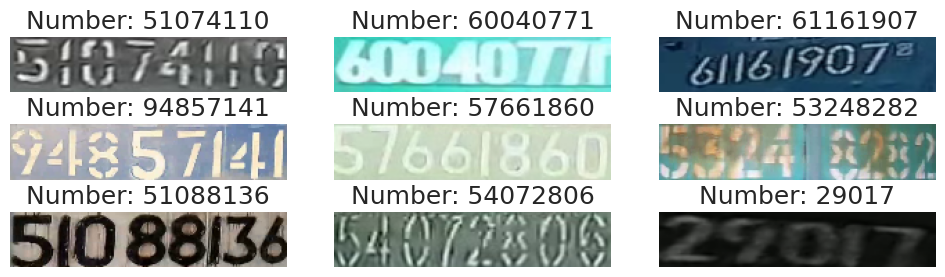

In [15]:
fig = plt.figure(figsize=(10, 3))

for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    image_path = df['image_path'][i]
    description = df['number'][i]

    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(f"Number: {description}")

plt.tight_layout()
plt.show()


### Обучение модели

Для проверки качества распознания возмём 600 случайных фото из датафрейма

In [16]:
df = df.sample(600)

Используем предобученную модель TrOCR

In [17]:
# загрузка предобученной модели
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
def process_image(image_path):

    image = Image.open(image_path)

    pixel_values = processor(images=[image], return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values)
    generated_number = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_number

In [19]:
# Добавление колонки 'recognition' с результатами распознавания
df['recognition'] = df['image_path'].apply(process_image)

In [20]:
# функция для удаления всех пробелов и знаков препинания
def remove_spaces_and_punctuation(s):
    return re.sub(r'\s|\W', '', s)

# Применение функции к столбцу
df['recognition'] = df['recognition'].apply(remove_spaces_and_punctuation)


In [21]:
# применим костыли
df['recognition'] = df['recognition'].apply(lambda x: x.replace('I', '1'))
df['recognition'] = df['recognition'].apply(lambda x: x.replace('l', '1'))
df['recognition'] = df['recognition'].apply(lambda x: x.replace('O', '0'))
df['recognition'] = df['recognition'].apply(lambda x: x.replace('U', '0'))


In [22]:
df['recognition'] = df['recognition'].astype(str)

При распозновании знаков или букв, номер будет переименован в заглушку "777"

In [23]:
# переведем в числовой формат
for index, value in df['recognition'].items():
    try:
        int_value = int(value)
        df.loc[index, 'recognition'] = int_value
    except ValueError:
        df.loc[index, 'recognition'] = 777


In [25]:
# пометим наши номера, как правильный ответ
df['y_true'] = 1

In [26]:
# разметим распознавания
def metrica(row):

    if row['recognition'] == row['number']:
        return 1
    return 0

df['y_pred'] = df.progress_apply(metrica, axis=1)


  0%|          | 0/600 [00:00<?, ?it/s]

In [30]:
# выведем точность распознавания
accuracy  = accuracy_score(df['y_true'], df['y_pred']).round(3)
accuracy

0.863

In [31]:
# финальный датасет
df

,filename,number,image_path,recognition,y_true,y_pred
3514,1_2019-10-21_05-27-274107,54285564,/content/test_rzd/images/1_2019-10-21_05-27-27...,54285564,1,1
5844,1_2019-12-02_06-39-06348,1909054,/content/test_rzd/images/1_2019-12-02_06-39-06...,1909054,1,1
12171,1594614895.149984_262,42304816,/content/test_rzd/images/1594614895.149984_262...,42304816,1,1
7196,1571138873593,54651757,/content/test_rzd/images/1571138873593.png,54651757,1,1
7892,1593678524.599081_359,95276424,/content/test_rzd/images/1593678524.599081_359...,95276424,1,1
...,...,...,...,...,...,...
6304,1_2019-10-21_04-23-23797,60972221,/content/test_rzd/images/1_2019-10-21_04-23-23...,60972221,1,1
586,1594984429.4078076_1043,56121718,/content/test_rzd/images/1594984429.4078076_10...,56121718,1,1
3860,1594293988.8068914_271,58701038,/content/test_rzd/images/1594293988.8068914_27...,58701038,1,1
1616,1593678524.599081_156,56350408,/content/test_rzd/images/1593678524.599081_156...,5050408,1,0


In [33]:
df_0 = df.query('y_pred == 0')

In [36]:
# сравним номера вагонов с номером распознавания
df_0.sample(10)

,filename,number,image_path,recognition,y_true,y_pred
6466,1594628578.4808843_320,92642149,/content/test_rzd/images/1594628578.4808843_32...,9264249,1,0
27,1594214128.6307085_506,52390382,/content/test_rzd/images/1594214128.6307085_50...,2390382,1,0
11698,1594293988.8068914_476,61177341,/content/test_rzd/images/1594293988.8068914_47...,51177341,1,0
3196,1594628578.4808843_176,59610857,/content/test_rzd/images/1594628578.4808843_17...,57610857,1,0
7743,1594984429.4078076_904,94470176,/content/test_rzd/images/1594984429.4078076_90...,924170176,1,0
1229,1593678524.599081_249,52131380,/content/test_rzd/images/1593678524.599081_249...,52131360,1,0
10233,1593678524.599081_136,54866710,/content/test_rzd/images/1593678524.599081_136...,54866718,1,0
2827,1594021800.096265_255,61394805,/content/test_rzd/images/1594021800.096265_255...,51394805,1,0
6960,1594014068.4331625_135,54179866,/content/test_rzd/images/1594014068.4331625_13...,54179666,1,0
9867,1594814342.4965706_861,57143992,/content/test_rzd/images/1594814342.4965706_86...,5743992,1,0


### Вывод

Точность распознания полного номера вагона (как единого целого) Accuracy = 0.863, что хуже YoloV8, другой подход к задаче, но было интересно его попробовать. Модель ошибает в зависимости от качества во всех цифрах, где-то вообще не распознаёт.